# UFP Demo with JAX-MD

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Robert-Schmid/uf3/blob/jax/examples/jax-md/jax-md-ufp-demo.ipynb)

In [1]:
#@title install UF3
# !git clone -b jax https://github.com/Robert-Schmid/uf3.git
# %cd /content/uf3
# !pip install -r requirements.txt
# !pip install -e .
# %cd /content/uf3/examples/jax-md

# !pip install -q git+https://www.github.com/google/jax-md

In [2]:
#@title JAX-MD Imports & Utils from the Cutom Potentials notebook from git:google/jax-md

import numpy as onp

import jax.numpy as jnp
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util

from functools import partial
import time
from typing import List

f32 = jnp.float32
f64 = jnp.float64
Array = jnp.ndarray

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def plot_system(R,box_size,species=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(jnp.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))
  
key = random.PRNGKey(0)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Importing potentials

We import the parameters from the 2-body ufp potentials trained on tungsten data in the pair_potential_demo notebook from the examples.

In [3]:
from uf3.representation import bspline
from uf3.data import composition
from uf3.regression import least_squares

element_list = ['W']
degree = 2

chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)

r_min_map = {('W', 'W'): 1.5,
            }
r_max_map = {('W', 'W'): 5.5,
            }
resolution_map = {('W', 'W'): 25,
                 }
trailing_trim = 3

bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

model = least_squares.WeightedLinearModel(bspline_config)

model.load(filename="../tungsten_extxyz/model_pair.json")

In [4]:
coefficients = jnp.asarray(model.coefficients[1:])
knots = [jnp.asarray(model.bspline_config.knots_map[('W','W')])]

print(coefficients)
print(knots)

[ 6.43001157e+00  5.97354258e+00  5.06058796e+00  3.69113106e+00
  1.65205855e+00  9.23859147e-01  2.81258202e-01 -5.36413561e-03
 -1.65669972e-01 -2.39954884e-01 -2.77954263e-01 -2.80998799e-01
 -2.49653066e-01 -1.77409590e-01 -1.00099852e-01 -6.82599769e-02
 -2.00034440e-02 -3.28071234e-02 -3.43219435e-02 -3.43618259e-02
 -2.88400639e-02 -2.12175439e-02 -6.90983500e-04 -9.25139031e-03
 -8.08694792e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[DeviceArray([1.5 , 1.5 , 1.5 , 1.5 , 1.66, 1.82, 1.98, 2.14, 2.3 , 2.46,
             2.62, 2.78, 2.94, 3.1 , 3.26, 3.42, 3.58, 3.74, 3.9 , 4.06,
             4.22, 4.38, 4.54, 4.7 , 4.86, 5.02, 5.18, 5.34, 5.5 , 5.5 ,
             5.5 , 5.5 ], dtype=float64)]


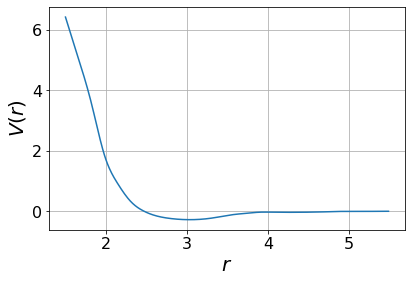

In [5]:
from uf3.jax.potentials import uf2_interaction

drs = jnp.arange(1.5,5.5,0.01)
f = partial(uf2_interaction(knots), coefficients=coefficients)
U = vmap(f)(drs)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

## Using the potential

### Creating a system

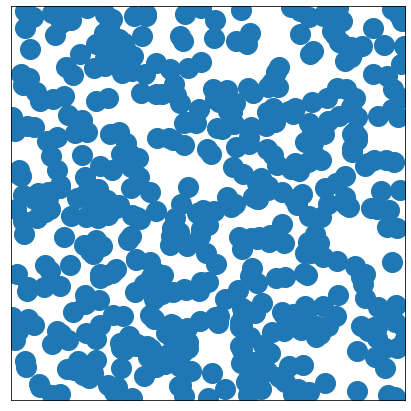

In [6]:
N = 500
dimension = 3
box_size = 12.0

key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

plot_system(R,box_size)

In [7]:
box = jnp.eye(dimension) * box_size
displacement, shift = space.periodic_general(box, fractional_coordinates=False)

### Calculating forces, energies and stress

In [8]:
from uf3.jax.potentials import uf2_pair
from uf3.jax.physical import stress_fn

# Create a function to calculate the total energy with specified parameters
energy_fn = uf2_pair(displacement, knots, coefficients=[coefficients])

# Use this to calculate the total energy
print(energy_fn(R))

# Use grad to calculate the net force
force = -grad(energy_fn)(R)
print(force[:5])

8066.2015972928375
[[ 15.29246937 -21.96925017 -47.47790003]
 [  8.78558524  26.88078789  39.43310416]
 [ 27.65639121 -43.59842966 -10.28381398]
 [ 48.83810166  15.77194653  30.69280333]
 [  3.76158447 -11.05976267  33.83882648]]


In [9]:
stress_f = stress_fn(energy_fn, box)
stress = stress_f(R)
print(stress)

[[-12.03743611   0.10508514  -0.03138277]
 [  0.10508514 -12.20308648   0.21933457]
 [ -0.03138277   0.21933457 -12.63328056]]


### More derivatives

Derivatives with repect to the coefficients for optimization.

In [10]:
ener = lambda c: energy_fn(R, coefficients=[c])
print(ener(coefficients))

print(grad(ener)(coefficients))

8066.2015972928375
[ 160.37334717  368.12070065  632.08003294  980.45964619 1139.72850551
 1316.3392145  1508.24849647 1723.00390321 2070.73198955 2334.69283493
 2578.98097283 2848.28391755 3100.96909546 3409.89792928 3738.23876044
 4017.95388362 4416.05098406 4795.10437873 5169.66063236 5588.45449047
 5797.7578996  6181.16415163 6703.32228449 7237.47285135 7734.06589475
 6145.31269448 4279.46787558 2184.06263221]


## Simple gradient descent with AD

Let's have a look at the lennard-jones potential defined in the JAX-MD package. Can we easily replicate this with our 2-body ufp potential?

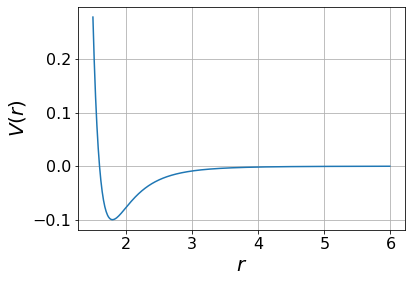

In [11]:
from jax_md.energy import lennard_jones, lennard_jones_pair

drs = jnp.arange(1.5,6.0,0.01)
U = lennard_jones(drs, sigma=1.6, epsilon=0.1)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

We use the mean squared error as a simple loss function.

In [12]:
drs = jnp.arange(1.5,6.0,0.01)

uf2_fn = uf2_interaction(knots)

uf2 = lambda drs, co: vmap(partial(uf2_fn, coefficients=co))(drs)
uf2_d = lambda drs, co: vmap(grad(partial(uf2_fn, coefficients=co)))(drs)
lj = lambda drs: lennard_jones(drs, sigma=1.6, epsilon=0.1)

def error_E(coefficients, drs):
    return jnp.power(jnp.sum((lj(drs) - uf2(drs, coefficients)) ** 2), 1/2) / len(drs)

def error_F(coefficients, drs):
    return jnp.power(jnp.sum((vmap(grad(lj))(drs) - uf2_d(drs, coefficients)) ** 2), 1/2) / len(drs)

In [13]:
c = jnp.zeros_like(coefficients)

grad(error_E)(c, drs)

DeviceArray([-2.21157979e-03, -6.50549074e-04,  1.97007321e-03,
              3.94738869e-03,  3.48373553e-03,  2.55616899e-03,
              1.79336063e-03,  1.25033737e-03,  8.78211861e-04,
              6.24596099e-04,  4.50558108e-04,  3.29709967e-04,
              2.44645288e-04,  1.83924655e-04,  1.39983206e-04,
              1.07764838e-04,  8.38477108e-05,  6.58854372e-05,
              5.22478841e-05,  4.17880222e-05,  3.36888406e-05,
              2.73615968e-05,  2.23773463e-05,  1.84203046e-05,
              1.52557019e-05,  9.86129634e-06,  5.87999374e-06,
              2.41942215e-06], dtype=float64)

Energy Error after 0 iterations: 0.0017599852240830298
Force Error after 0 iterations:  0.022636380612821805
Energy Error after 10 iterations: 0.0013171096153614084
Force Error after 10 iterations:  0.020352420324010093
Energy Error after 20 iterations: 0.0009855544714351275
Force Error after 20 iterations:  0.017979915590632636
Energy Error after 30 iterations: 0.0007537195535970287
Force Error after 30 iterations:  0.01556638935714798
Energy Error after 40 iterations: 0.0005779410944777154
Force Error after 40 iterations:  0.013139827332851104
Energy Error after 50 iterations: 0.00042578819234292617
Force Error after 50 iterations:  0.010666317972319381
Energy Error after 60 iterations: 0.0002873437946132685
Force Error after 60 iterations:  0.00808616615658807
Energy Error after 70 iterations: 0.00016300107763916256
Force Error after 70 iterations:  0.005362312014570317
Energy Error after 80 iterations: 5.8556852928237925e-05
Force Error after 80 iterations:  0.0025518313755008236
E

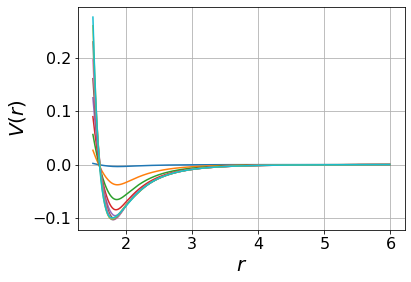

In [14]:
drs = jnp.arange(1.5,6.0,0.01)

c = jnp.zeros_like(coefficients)

loss = jit(grad(error_E))
error = jit(error_E)
uf2 = jit(uf2)

for i in range(100):
    dc = loss(c, drs)
    c -= dc

    if i % 10 == 0:
        print(f"Energy Error after {i} iterations: {error(c, drs)}")
        print(f"Force Error after {i} iterations:  {error_F(c, drs)}")
        U = uf2(drs, c)
        plt.plot(drs,U)

format_plot(r'$r$', r'$V(r)$')
finalize_plot()

Total error on the energies within the knot range: 0.005412076997695881


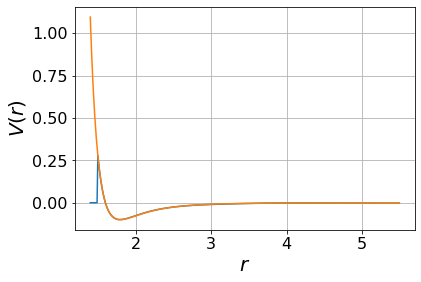

In [15]:
drs = jnp.arange(1.4,5.5,0.01)

print(f"Total error on the energies within the knot range: {error(c, drs)}")

U = uf2(drs, c)
plt.plot(drs,U)
U = lennard_jones(drs, sigma=1.6, epsilon=0.1)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

### Data efficiency

In [16]:
loss = jit(grad(error))
error = jit(error)
error_F = jit(error_F)

def error_after_training(training_set, iterations, reference):
  c = jnp.zeros_like(coefficients)
  E_error = []
  F_error = []
  for data in training_set:
    for i in range(iterations):
      dc = loss(c, data)
      c -= dc
    E_error.append(error(c, reference))
    F_error.append(error_F(c, reference))
  return (E_error, F_error)

In [17]:
training_sets = []
X = [1,5,10,20,50,100,250,500,1000,5000]

rng = onp.random.default_rng(12345)

for i in X:
  tmp = jnp.asarray(rng.uniform(1.5,5.5,i))
  training_sets.append(jnp.sort(tmp))

print(training_sets[1])

[2.76703336 2.83125571 3.0644382  4.20501868 4.68946183]


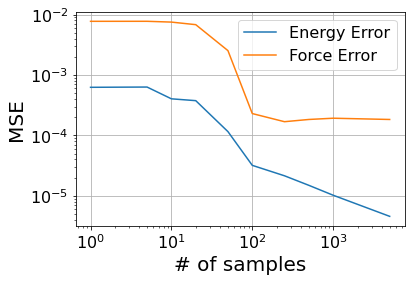

In [18]:
fine_sampling = jnp.arange(1.5,5.5,0.001) # 4000 data points with uniform spacing
reference = fine_sampling
# reference = training_sets[-1]
n_steps = 500 # number of steps in the gradient descent

Ee, Fe = error_after_training(training_sets, n_steps, reference)
plt.loglog(X,Ee, label="Energy Error")
plt.loglog(X,Fe, label="Force Error")
format_plot("# of samples", "MSE")
plt.legend()
finalize_plot()
# plt.savefig('sample_size.png')

## Realistic reference Energies

In [19]:
from uf3.jax.training import regularizer

In [20]:
# k = jnp.arange(1.5,6.0,0.5)

k = knots[0]

drs = jnp.arange(1.5,6.0,0.01)
uf2_fn = uf2_interaction(knots)

uf2 = lambda drs, co: vmap(partial(uf2_fn, coefficients=co))(drs)
uf2_d = lambda drs, co: vmap(grad(partial(uf2_fn, coefficients=co)))(drs)
lj = lambda drs: lennard_jones(drs, sigma=1.6, epsilon=0.1)

def error(coefficients, drs, lam=0.0, kappa=0.5):
    tE = jnp.sum(lj(drs))
    tF = vmap(grad(lj))(drs)
    E = jnp.sum(uf2(drs, coefficients))
    F = uf2_d(drs, coefficients)

    n_atoms = len(tF)

    e_loss =  jnp.sum((tE - E) ** 2) #/ (n_atoms)# * jnp.var(tE))
    f_loss =  jnp.sum((tF - F) ** 2) / (n_atoms * jnp.var(tF))
    reg = lam * regularizer(coefficients)
    return kappa * e_loss + (1-kappa) * f_loss + reg


Taking derivatives with respect to the coefficients.

In [21]:
c = jnp.zeros_like(coefficients)

grad(error)(c, drs, lam=0.005, kappa=0.5)

DeviceArray([22.21790208, 47.41505605, 69.22588193, 91.31673212,
             90.93821891, 90.86971563, 90.86614458, 90.87373237,
             90.88108024, 90.88642256, 90.89001778, 90.89238367,
             90.89393775, 90.89496579, 90.89565335, 90.89611904,
             90.89643864, 90.89666086, 90.89681734, 90.89692888,
             90.89700931, 90.89706795, 90.89711114, 90.89714326,
             90.89716738, 68.17288671, 45.35980603, 19.97229602],            dtype=float64)

A simple gradient descent loop without regularization.
This is enough for our simple demonstartion, but can produce 'wobbly' results on some problems.

Loss error after 10 iterations: 0.026434403261520557
Loss error after 15 iterations: 0.023646077003841654
Loss error after 35 iterations: 0.017258400546799814
Loss error after 50 iterations: 0.014724105090107204


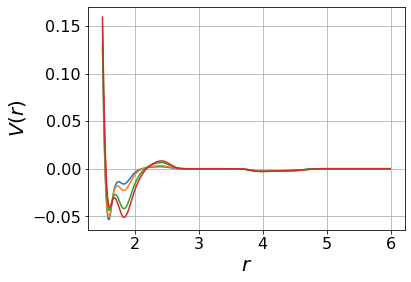

In [22]:
drs = jnp.concatenate([jnp.arange(4.0,4.5,0.02), jnp.arange(4.0,4.5,0.02), jnp.arange(4.0,4.5,0.02), jnp.arange(1.5,2.5,0.2)])
ref = jnp.arange(1.5,6.0,0.01)
# drs = jnp.arange(1.5,6.0,0.1)

c = jnp.zeros_like(coefficients)
# rng = onp.random.default_rng(123)
# c = jnp.asarray(rng.uniform(-1.0, 1.0, coefficients.shape))
loss = jit(grad(error))
error = jit(error)
uf2 = jit(uf2)
regularize = 0.05
k=0.05

err = error(c, drs, lam=regularize, kappa=k)
last = 0
step = 10

iterations = 50

for i in range(1,iterations+1):
    dc = loss(c, drs, lam=regularize, kappa=k)
    c -= dc * 0.01

    if i % step == 0 or i == iterations:
        new_err = error(c, drs, lam=regularize, kappa=k)
        # only print the current funciton if the error reduced by more than 20%
        # increase step size before next error computation
        if abs(err - new_err) / err > 0.2 or i == iterations or True:
            err = new_err
            step = step + (i - last)/2
            last = i
            print(f"Loss error after {i} iterations: {err}")
            # print(f"Test error after {i} iterations: {error(c, ref, kappa=1.0)}")
            U = uf2(ref, c)
            plt.plot(ref,U)

format_plot(r'$r$', r'$V(r)$')
finalize_plot()

# plt.savefig('data_imbalance.png')
# plt.savefig('random_start_params.png')

We are quite close to the lennard-jones potential within the knot range (1.5 to 5.5). But the current ufp JAX implementation returns to zero outside the knot range.

Total error on the energies within the knot range: 3.1041961198738157
Total error on the energies on the training data: 0.0025349100356040584


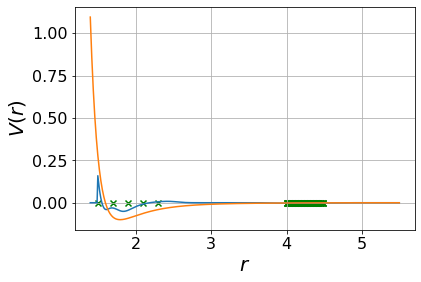

In [23]:
ref = jnp.arange(1.4,5.5,0.01)

print(f"Total error on the energies within the knot range: {error(c, ref)}")
print(f"Total error on the energies on the training data: {error(c, drs)}")

U = uf2(ref, c)
plt.plot(ref,U)
U = lennard_jones(ref, sigma=1.6, epsilon=0.1)
plt.plot(ref,U)
plt.scatter(drs,jnp.zeros_like(drs), marker="x", color="green")
format_plot(r'$r$', r'$V(r)$')
finalize_plot()
# plt.savefig('reference_data.png')

### Data efficiency

In [24]:
loss = jit(grad(error))
error = jit(error)

def iteration_test(training_set, iterations, reference, start):
  out = []
  # for iter in iterations:
  c = jnp.asarray(start.copy())
  for i in range(iterations[-1]+1):
    dc = loss(c, training_set, lam=0.05, kappa=0.5)
    c -= dc * 0.01
    if i in iterations:
      out.append(error(c, reference, lam=0.05, kappa=0.5))
  return out

In [25]:
iterations = list(range(50,5001,50))

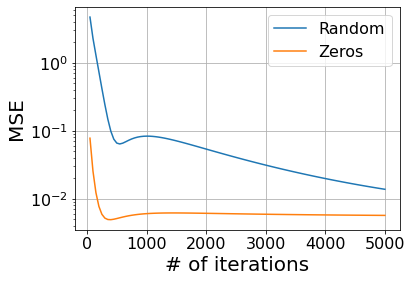

In [26]:
fine_sampling = jnp.arange(1.5,5.5,0.01)
reference = fine_sampling

drs = jnp.arange(1.5,6.0,0.1)

rng = onp.random.default_rng(123)
start_random = rng.uniform(-1.0, 1.0, coefficients.shape)
start_zero = onp.zeros_like(coefficients)

U1 = iteration_test(drs, iterations, reference, start_random)
U2 = iteration_test(drs, iterations, reference, start_zero)
plt.plot(iterations, U1, label="Random")
plt.plot(iterations, U2, label="Zeros")
plt.yscale('log')
plt.legend()
format_plot("# of iterations", "MSE")
finalize_plot()
# plt.savefig('loss_decay.png')